# Calculate metrics using climpred

---

Now that all of our model and observational data is ready for analysis, we can run this notebook and calculate various metrics using climpred across all models and seasons and compare how they do. It is recommended that you use `dask` to run this notebook as we are looking at geospatial data and making maps. You can start up a `dask` cluster by running the notebook `cluster.ipynb` and copying the Scheduler tcp number into this notebook.

In [2]:
import cftime
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import climpred
import intake
from tqdm import tqdm
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import xskillscore as xs
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

- Make sure you have copied the correct tcp here from the `cluster.ipynb` notebook

In [3]:
client = Client("tcp://10.12.206.46:40172")

## Here is where you choose your variable, metric and start/end time.

In [4]:
variable = "t2m" #can be t2m, tp, gh_500
metric = "rmse" #can be rps, rmse, acc
data = "anom" #can be anom or raw
lead = "biweekly" #biweekly or daily
area = "geospatial"
start = "1999-01-01"
end = "2020-12-31" 
models = ["ECMWF","CESM2","NCEP"] #this notebook uses all three of these models #ECCC

In [5]:
# Here we are just setting options for the different metrics and mapping.
if metric == "acc":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="RdBu_r" #options for maps
elif metric=="rmse":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="viridis" #options for maps
elif metric=="rps":
    comp="m2o"; dim=["init","member"]; ens="" #options for metrics
    cmap="viridis" #options for maps

## Now we read in and load the data into `dask`

We are using the intake catalog to find the data and load it up. Make sure you have the file `ASP_data_catalog.yml` in your local directory. Or you can find it here: `/glade/campaign/mmm/c3we/jaye/S2S_zarr/`

We have an `if` statement here telling us to load in category_edge files, only if our metric of choice is `rps`

In [6]:
cat = intake.open_catalog('ASP_data_catalog.yml')

In [7]:
hinds = {}
for m in models:
    hinds[m] = cat[m](data=data, lead=lead, dim=area).to_dask().astype('float32')
verif = cat['OBS'](data=data, lead=lead, dim=area).to_dask().astype('float32')

In [8]:
#hinds[m] = cat[m](data=data, lead=lead, dim=area).sel(lon=)(lat=).to_dask().astype('float32')

In [9]:
if data == "raw":
    verif=verif+273.15

In [10]:
#search documentation for datetime (dt) (pandas)
#pd.DatetimeIndex(dates)
#hinds["ECMWF"].init.dt.month
#hinds["ECMWF"].init.dt.dayofyear
#hinds["ECMWF"].sel(init=hinds["ECMWF"].init.dt.month==4)
#hinds["ECMWF"].sel(init=hinds["ECMWF"].init.dt.month==(3,4))
#hinds["ECMWF"].sel(init=hinds["ECMWF"].init.dt.dayofyear==90)

In [11]:
#search documentation for datetime (dt) in pandas pd.DatetimeIndex(dates)
hind_sub=hinds["ECMWF"].sel(init=hinds["ECMWF"].init.dt.dayofyear==92)  #04/02
#hind_sub=hinds["ECMWF"].sel(init=hinds["ECMWF"].init.dt.dayofyear==99) #04/09
#hind_sub=hinds["ECMWF"].sel(init=hinds["ECMWF"].init.dt.dayofyear==85) #03/26

In [12]:
#Select gridcell over of Buffalo Bill Reservoir
#(43.5 - 45N; 110.5 - 108.5W;  spring forecast)
#latpick="43.5"
#lonpick="109.5"
#hinds["ECMWF"].sel(lon=lonpick,lat=latpick).drop('lat').drop('lon')
#verif.sel(lon=lonpick,lat=latpick).drop('lat').drop('lon')

- All of the model data is now loaded into a dictionary so that we can have them all together for comparison purposes.

In [13]:
# is seasonal data available for all models and rechunk
for h in hinds:
    print(hinds[h].init.dt.season.to_index().unique(), 'freq =',hinds[h].init.to_index().freq) # freq would show weekly but calendar conversion breaks this
    #hinds[h] = hinds[h].chunk({"member": "auto", "init": -1, "lead": "auto", "lat": 45, "lon": 60}).persist()
    hinds[h] = hinds[h].chunk({"member": -1, "init": -1, "lead": "auto", "lat": 45, "lon": 60}).persist() #changed for rps
    hinds[h] = hinds[h].sel(init=slice(start,end))
verif = verif.sel(time=slice(start,end))
verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})

Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None


## Create a Hindcast Ensemble in climpred for each of the models and run metrics

We are also setting kwargs (options) for `verify` in climpred. The second cell does the metric calculation using `verify` and computes it. Finally all models are concatenated together and plotted.

This could take a few minutes to run. If you are curious, check out the `dask` dashboard and you can watch the progress of the computations. The link should be like this: `https://jupyterhub.hpc.ucar.edu/stable/user/jaye/proxy/37030/status`. The number between proxy and status will vary. Your link will be available where you started your dask cluster in `cluster.ipynb`

In [14]:
he = {}
met = {}
for h in hinds:
    print(h)
    he[h] = climpred.HindcastEnsemble(hinds[h]).add_observations(verif)
    if metric=="rps":
        metric_kwargs = dict(metric=metric, comparison=comp, dim=dim, alignment="same_inits")
        met[h] = he[h].verify(category_edges=(verif_edges, hinds_edges[h]),**metric_kwargs)
    else:
        metric_kwargs = dict(metric=metric, comparison=comp, dim=dim, alignment="same_inits", skipna=True)
        met[h] = he[h].verify(**metric_kwargs)
    met[h] = met[h].compute()

ECMWF
CESM2
NCEP


In [15]:
met_all = xr.concat([met[models[0]], met[models[1]], met[models[2]]], dim='model') \
          .assign_coords(model=[models[0], models[1], models[2]])

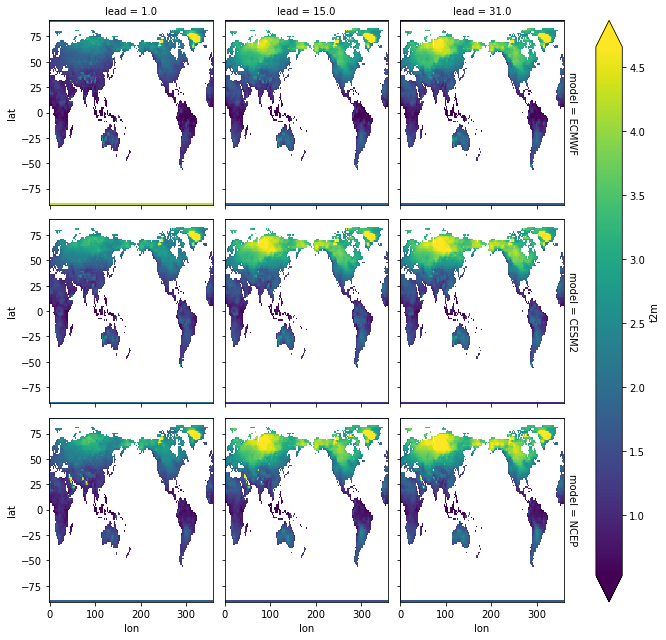

In [16]:
met_all[variable].plot(col='lead',row='model',cmap=cmap,robust=True)

## Seasonal data

Now we will create seasonal averages of the data. Prior to this we have been looking at annual data. We use `groupby` here to group into seasons and then run `verify` over each of the seasons and models for the metric of our choice. They are then concatenated together and plotted for `lead=15` (weeks 3-4).

In [18]:
groupby = "season"
met_seas = {}
for h in hinds:
    met_groups = []
    label_groups = []
    # Loops through all inits for a given season.
    for label_group, group in tqdm(he[h].get_initialized().groupby(f"init.{groupby}")):
        # select only season inits
        if metric=="rps":
            met_group = he[h].sel(init=group.init).verify(category_edges=(verif_edges, hinds_edges[h]),**metric_kwargs)
        else:
            met_group = he[h].sel(init=group.init).verify(**metric_kwargs)
        met_groups.append(met_group)
        label_groups.append(label_group)
    met_groups = xr.concat(met_groups, dim=groupby).assign_coords(season=label_groups)
    met_seas[h] = met_groups.compute()

100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


TypeError: 'Future' object is not subscriptable

In [ ]:
met_seas_all = xr.concat([met_seas[models[0]], met_seas[models[1]], met_seas[models[2]]], dim='model') \
               .assign_coords(model=[models[0], models[1], models[2]])


In [ ]:
met_seas_all.sel(lead=1)[variable].plot(col=groupby, row='model',cmap=cmap, robust=True)

In [ ]:
met_seas_all.isel(lat=1,lon=20).t2m

In [ ]:
met_seas_all.sel(lead=15)[variable].plot(col=groupby, row='model',cmap=cmap, robust=True)

## Area weighting

Next we run cosine area weighting over that data to get a weighted lat/lon average over the domain. We then print out the weights and plot them on bar charts to compare different seasons and models.

In [ ]:
weight = met_seas_all.weighted(np.cos(np.deg2rad(met_seas_all.lat))).mean(("lat", "lon"))[variable].drop('skill')

In [ ]:
weight

In [ ]:
seasons = np.array(weight.season)
barWidth = 0.25
rw = np.arange(3)
rw1 = [x + barWidth + 0.025 for x in rw]
rw2 = [x + barWidth + 0.025 for x in rw1]
#For ACC
if weight.min() < 0.:
    ymin = weight.min()*0.6+weight.min()
else:
    ymin = 0.0
ymax = weight.max()*0.6+weight.max()
for s in seasons:
    plt.bar(rw,weight.sel(season=s,model=models[0]), width = barWidth, color = (0, 0.4470, 0.7410), edgecolor="white",label=models[0])
    plt.bar(rw1,weight.sel(season=s,model=models[2]), width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.8,edgecolor="white",label=models[2])
    plt.bar(rw2,weight.sel(season=s,model=models[1]), width = barWidth, color = (0.4, .75, 0.1), alpha=0.8,edgecolor="white",label=models[1])
    plt.xticks([r + barWidth + 0.025 for r in range(3)], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
    #plt.ylim(ymin,ymax)
    plt.ylabel(metric.upper(),fontsize=18,fontweight="bold")
    plt.xlabel("Week",fontsize=18,fontweight="bold")
    plt.grid()
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15},loc="upper right")
    plt.title(variable.upper()+" "+metric.upper()+" for season = "+s,fontsize=18,fontweight="bold")
    plt.show()

## Create a Hindcast Ensemble in climpred for each of the models and compute terciles 

In [ ]:
metric='rps'

In [ ]:
groupby_time = 'dayofyear'

In [ ]:
# Read in terciles
# verif_edges is a function of dayoftheyear, so thats 365 calendar days
if metric == "rps":
    hinds_edges = {}
    for m in models:
        hinds_edges[m] = cat['cat_edges'](data=data, model=m, lead=lead, dim=area).to_dask().astype('float32') \
                         .chunk({"category_edge": -1, "dayofyear": -1, "lat": 45, "lead": -1, "lon": 60}).persist()
    verif_edges = cat['cat_edges'](data=data, model='OBS', lead=lead, dim=area).to_dask().astype('float32') \
                 .chunk({"category_edge": -1, "dayofyear": -1, "lat": 45, "lon": 60}).persist()

In [ ]:
#Compute terciles of verification 
#%time verif_edges = verif.chunk({'time':-1,'lon':'auto'}).groupby(f'time.{groupby_time}').quantile(q=[1./3.,2./3.], dim='time', skipna=False).rename({'quantile':'category_edge'}).astype('float32').compute()

In [ ]:
#Compute terciles of forecast
#hind_edges is also a function of dayoftheayear, but for weekly data only dayoftheyear:[ 2,   9,  16,  23,...]
#hind_edges["t2m"].isel(lead=1).isel({groupby_time:[1,45]}).plot(row='category_edge', cmap='seismic', col=groupby_time, robust=True)
#verif_edges["t2m"].isel({groupby_time:[8,92]}).plot(row='category_edge', col=groupby_time, robust=True)
#hinds_edges={}
#hinds_edges["ECMWF"] = he["ECMWF"].get_initialized().groupby(f'init.{groupby_time}').quantile(q=[1./3.,2./3.], dim=['init','member'], skipna=False).rename({'quantile':'category_edge'}).astype('float32').persist()

In [ ]:
#Plot terciles 
pickdayofyear=92
verif_edges["t2m"].isel({groupby_time:[8,pickdayofyear]}).plot(row='category_edge', cmap='seismic',col=groupby_time, robust=True)

In [ ]:
#hinds_edges["ECMWF"].t2m.isel(lead=1).isel({groupby_time:[1,18]}).plot(row='category_edge', cmap='seismic', col=groupby_time, robust=True)
hinds_edges["ECMWF"].t2m.isel(lead=1).isel({groupby_time:[1,18]}).plot(row='category_edge', cmap='seismic', col=groupby_time, robust=True)

# Pick a particular date

In [ ]:
#pickfc=hinds["ECMWF"].(init.dt.dayofyear==pickdayofyear).drop("init").mean("member")
#Doing aligmenent by hand init="2004-04-02" - two weeks
hinds["ECMWF"].sel(init="2004-03").init
pickfc=hinds["ECMWF"].sel(init="2004-03-26").drop("init").mean("member")
pickfc.t2m.plot(col='lead',cmap='seismic')
pickfc=pickfc.isel(lead=1).drop("lead")

In [ ]:
#pickverif=verif.(init.dt.dayofyear==pickdayofyear)
pickverif=verif.sel(time="2004-04-02")
pickverif.t2m.plot(cmap='seismic')

In [ ]:
clim_dist=hinds_edges["ECMWF"].isel(category_edge=1).isel(dayofyear=pickdayofyear).drop("category_edge").drop("dayofyear") #hack in april
clim_dist=clim_dist.sel(lead=1).drop("lead")

In [ ]:
verif_dist=verif_edges.isel(category_edge=1).isel(dayofyear=pickdayofyear).drop("category_edge").drop("dayofyear")

In [ ]:
uqfc=pickfc-clim_dist
uqvf=pickverif-verif_dist
uqvf.t2m.plot()

In [ ]:
uqfc.t2m.plot()